## Vanilla Classification on Full Dataset
This notebook contains first vanilla run of several classification models on the full dataset. 

In [51]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import gzip

from yellowbrick.classifier import ConfusionMatrix



### Data Preprocessing

In [52]:
# import data and convert to pandas dataframe
dataset = pd.read_parquet('newdata_v2.parquet', engine = 'pyarrow')

In [53]:
# check if read correctly
dataset.head()

,lat,lon,MaxFRP,EVI,EVI2,NVDI,NIR_reflectance,SWIR1_reflectance,SWIR2_reflectance,SWIR3_reflectance,...,SoilTMP100_200cm_inst,SoilTMP10_40cm_inst,SoilTMP40_100cm_inst,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,Uncertainty,QA,label
0,-46.173406,106.360530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
1,-46.173406,106.405485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
2,-46.173406,106.450441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
3,-46.173406,106.495396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
4,-46.173406,106.540352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water


In [54]:
# check class imbalance
dataset['label'].value_counts()

water           649240
burned          369925
fwi_high         11823
land              2463
fwi_moderate       732
active_fire        193
Name: label, dtype: int64

In [55]:
# Split data into X and y
# Need to save coordinates AFTER train test split in order to merge at end

X = dataset.drop('label', axis = 1)
y = dataset['label']

# Predicting categories: ['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire']

In [56]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

In [57]:
# Save coordinates
train_coords = X_train.loc[:,['lat', 'lon']]
test_coords = X_test.loc[:,['lat', 'lon']]

# Drop coordinates from dataset
X_train.drop(['lat','lon'], axis = 1, inplace = True)
X_test.drop(['lat','lon'], axis = 1, inplace = True)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
# Preprocessing steps

# Scale Data
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

# Binarizing is part of OneVsRestClassifier implementation

### Multiclass Logisitic Regression

In [59]:
lr = LogisticRegression(penalty = 'l1', solver = 'saga', n_jobs = -1)

In [60]:
trained_model = lr.fit(x_train, y_train)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [61]:
trained_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
# Save trained model
dump(trained_model, 'lg_newv2.joblib')

['lg_newv2.joblib']

In [63]:
y_pred_train = trained_model.predict(x_train)

In [64]:
# for some reason, balanced_accuracy_score is not importing
balanced_accuracy_score(y_train, y_pred_train)

0.3654110454659662

In [65]:
y_pred_test = trained_model.predict(x_test)
balanced_accuracy_score(y_test, y_pred_test)

0.35619173838702506

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/jupyter/.local/lib/python3.5/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


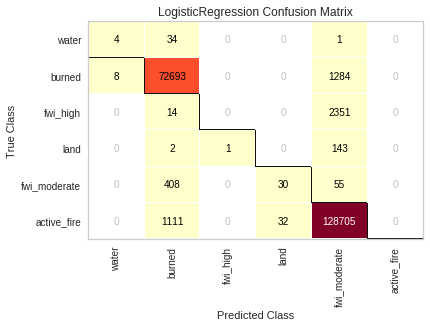

In [66]:
cm_train = ConfusionMatrix(trained_model, classes =['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire'])
cm_train.score(x_test, y_test)
cm_train.show()

### Check Trained Model

In [5]:
lg_v1 = load('lg_v1.joblib') 

In [6]:
y_pred_all = lg_v1.predict(X)

In [7]:
dataset_pred = dataset.loc[:,['lat', 'lon']]

In [8]:
dataset_pred['y_pred'] = y_pred_all

In [9]:
dataset_pred['y_pred'].value_counts()

water           35031498
fwi_extreme      9627363
burned           7620688
fwi_low           288418
fwi_veryhigh      162481
Name: y_pred, dtype: int64

In [9]:
dataset_pred['map'] = 0
dataset_pred.loc[(dataset_pred['y_pred']=='water'), 'map'] = 0
dataset_pred.loc[(dataset_pred['y_pred']=='fwi_extreme'), 'map'] = 4
dataset_pred.loc[(dataset_pred['y_pred']=='burned'), 'map'] = 2
dataset_pred.loc[(dataset_pred['y_pred']=='fwi_low'), 'map'] = 1
dataset_pred.loc[(dataset_pred['y_pred']=='fwi_veryhigh'), 'map'] = 3

In [10]:
dataset_pred.drop('y_pred', axis = 1, inplace = True)

In [23]:
dataset_pred.head()

,lat,lon,map
0,4.3625,96.329167,0
1,4.3625,96.337500,0
2,4.3625,96.345833,0
3,4.3625,96.354167,1
4,4.3625,96.362500,1


In [29]:
dataset_pred.memory_usage().sum()/1000000

1265.53088

In [11]:
dataset_pred.to_parquet('dataset_pred.parquet', engine = 'pyarrow')

In [12]:
import fastparquet

pfile = fastparquet.ParquetFile('dataset_pred.parquet')
with open('dataset_pred.csv', 'w') as fp:
    for i, df in enumerate(pfile.iter_row_groups()):
        write_header = (i==0)
        df.to_csv(fp, index=False, header=write_header)

AttributeError: module 'snappy' has no attribute 'compress'

In [14]:
!pip install --user python-snappy

  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-u5t5oe4h/python-snappy/setup.py'"'"'; __file__='"'"'/tmp/pip-install-u5t5oe4h/python-snappy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-_dhbzdkp --python-tag cp35
       cwd: /tmp/pip-install-u5t5oe4h/python-snappy/
  Complete output (26 lines):
  /usr/lib/python3.5/distutils/dist.py:261: UserWarning: Unknown distribution option: 'cffi_modules'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.5
  creating build/lib.linux-x86_64-3.5/snappy
  copying snappy/snappy_cffi.py -> build/lib.linux-x86_64-3.5/snappy
  copying snappy/snappy_formats.py -> build/lib.linux-x86_64-3.5/snappy
  copying snappy